# Are ICSD Compounds Missing from OQMD in Predictions?
The OQMD is missing many compounds from the ICSD. Here, we are testing wehther these missing compounds are "found" by our Deep Learning model.

In [1]:
%matplotlib inline
from matminer.featurizers.composition import ElementFraction
from sklearn.neighbors import NearestNeighbors
from pymatgen import Composition
from pymatgen.util.string import latexify
import os
import pandas as pd
from multiprocessing import Pool
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import comb
import pickle

Make useful tools

In [2]:
ef_gen = ElementFraction()

## Load in the missing ICSD compounds from the OQMD
Find which ICSD compounds are missing from the OQMD. These were generated by parsing the composition out of all ICSD cifs (available on Wolverton group clusters)

In [3]:
with open('compositions.list') as fp:
    compositions = set([Composition(x) for x in fp])
print('Read in %d unique ICSD compositions'%len(compositions))

Read in 90831 unique ICSD compositions


Get all of the elements in the OQMD, minus He, Ne, Ar

In [4]:
with open('oqmd_elements.list') as fp:
    oqmd_elements = set([x.strip() for x in fp.readlines()])
oqmd_elements.difference_update(['He','Ne','Ar'])
print('Total of 86 elements in search space')

Total of 86 elements in search space


Get entries with only OQMD elements

In [5]:
def has_only_oqmd_elements(composition):
    return len(set([x.symbol for x in composition.keys()]).difference(oqmd_elements)) == 0
assert not has_only_oqmd_elements(Composition('Am'))
assert not has_only_oqmd_elements(Composition('AmO'))
assert has_only_oqmd_elements(Composition('NaCl'))

In [6]:
compositions = np.array([x for x in compositions if has_only_oqmd_elements(x)])
print('%d of these compositions have only OQMD elements'%len(compositions))

90632 of these compositions have only OQMD elements


Build a NN lookup tool. 

Note: It would be more efficient to build this array for the other, larger datasets. But, building a KDTree for 1M entries is prohibitive on my system.

In [7]:
%%time
icsd_nn = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(
    [ef_gen.featurize(x) for x in compositions]
)

CPU times: user 20.7 s, sys: 152 ms, total: 20.8 s
Wall time: 20.8 s


## Load the Datasets
We need both the training set and predictions

### DL Predictions
These data files contain the compositions that are predicted to be stable

In [8]:
%%time
def load_DL_predictions(path):
    """Loads in the predictions from Dipendra, and renames the `delta_e` column to match the `oqmd_data`
    
    Also generates a `PDEntry` for each composition, and computes which system this entry is in
    """
    output = pd.read_csv(path, sep=' ')
    output.rename(columns={'delta_e_predicted': 'delta_e'}, inplace=True)
    output['comp_obj'] = output['composition'].apply(lambda x: Composition(x))
    return output
dl_predictions = dict([(x, load_DL_predictions(os.path.join('new-datasets', '%s_stable-0.2.data.gz'%x)))
     for x in ['binary', 'ternary', 'quaternary']
 ])

CPU times: user 9min 18s, sys: 5.96 s, total: 9min 24s
Wall time: 9min 24s


Remove predictions outside our search space

In [9]:
%%time
for k in dl_predictions:
    matches = [has_only_oqmd_elements(x) for x in dl_predictions[k]['comp_obj']]
    dl_predictions[k] = dl_predictions[k][matches]
del matches

CPU times: user 36.4 s, sys: 246 ms, total: 36.7 s
Wall time: 36.7 s


### OQMD Training Set
Get the near-stable compositions in the training set

In [10]:
oqmd_data = pd.read_csv('oqmd_all.txt', delim_whitespace=True).query('delta_e > -20')

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Get the non-crazy compositions.

In [11]:
oqmd_data['stability'] = pd.to_numeric(oqmd_data['stability'], errors='coerce')

In [12]:
oqmd_data.query('delta_e < 1', inplace=True)
print('Loaded %d training entries'%len(oqmd_data))

Loaded 476399 training entries


## Question 1: Which ICSD compositions are not in the training set?

Find the nearest composition to many of these 

In [13]:
%%time
icsd_dist, icsd_ind = icsd_nn.kneighbors([ef_gen.featurize(Composition(x)) for x in oqmd_data['comp']])

CPU times: user 4h 2min 21s, sys: 571 ms, total: 4h 2min 22s
Wall time: 30min 55s


Plot a histogram

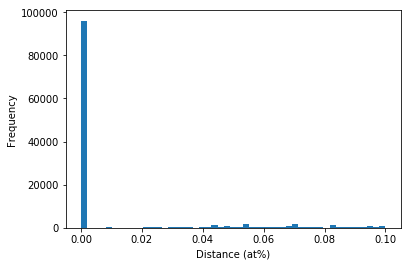

In [14]:
fig, ax = plt.subplots()

ax.hist(icsd_dist, np.linspace(0, 0.1))

ax.set_xlabel('Distance (at%)')
ax.set_ylabel('Frequency')

_Finding_: 0.01 seems reasonable. 

In [15]:
match_cutoff = 0.01

In [16]:
oqmd_matched = sum(icsd_dist < match_cutoff)
print('%d/%d (%.1f%%) OQMD entries match an ICSD entry'%(oqmd_matched, len(oqmd_data),
                                                               float(oqmd_matched)/len(oqmd_data)*100))

96616/476399 (20.3%) OQMD entries match an ICSD entry


In [17]:
icsd_matched = len(set(icsd_ind[icsd_dist<match_cutoff]))
print('%d/%d (%.1f%%) ICSD entries match an OQMD entry'%(icsd_matched, len(compositions),
                                                             float(icsd_matched)/len(compositions)*100))

28361/90632 (31.3%) ICSD entries match an OQMD entry


Eliminate ICSD compositions that were matched to the OQMD

In [18]:
not_matched = set(range(len(compositions))).difference(set(icsd_ind[icsd_dist<match_cutoff]))
print('%d ICSD compositions are not found in the OQMD'%len(not_matched))

62271 ICSD compositions are not found in the OQMD


In [19]:
icsd_not_oqmd_compositions = compositions[list(not_matched)]

In [20]:
with open(os.path.join('icsd-search', 'icsd-not-matched.list'), 'w') as fp:
    for c in icsd_not_oqmd_compositions:
        print(latexify(c.get_integer_formula_and_factor()[0]), file=fp)

Count the number of compounds with each number of elements

In [21]:
for s in range(1,7):
    print('%d %s-element compounds'%(sum([len(x) == s for x in icsd_not_oqmd_compositions]), s))

0 1-element compounds
3472 2-element compounds
18157 3-element compounds
19945 4-element compounds
12577 5-element compounds
5367 6-element compounds


Estimate how many compounds we'd find by random guess.

Here, we assume that exactly one composition matches an ICSD compound. The likely number we find is then: 

`<number of missing ICSD compounds> * <number of guesses made> / <search_space_size>`


In [22]:
number_dl_predictions = dict([(k,len(v)) for k,v in dl_predictions.items()])

In [23]:
search_space_size = comp_per_system = {
    'binary':31*comb(89,2,True),
    'ternary':109*comb(89,3,True),
    'quaternary': 205*comb(89,4,True)
}

In [24]:
expected_number_found = dict([
    (k,sum([len(x) == s for x in icsd_not_oqmd_compositions])/search_space_size[k]*number_dl_predictions[k])
    for k,s in zip(['binary','ternary','quaternary'],[2,3,4])
])

In [25]:
expected_number_found

{'binary': 44.788559754851896,
 'quaternary': 217.98596742798327,
 'ternary': 241.93440824217777}

Make a new distance computer

In [26]:
icsd_not_oqmd_nn = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(
    [ef_gen.featurize(x) for x in compositions[list(not_matched)]]
)

## Match DL Predictions to ICSD Compounds
Here, the goal is to find which ICSD compositions match up to at least one DL predictions

In [27]:
def match_compositions(predictions):
    """Find which ICSD compositions match a DL prediction"""
    
    icsd_dist, icsd_inn = icsd_not_oqmd_nn.kneighbors([ef_gen.featurize(x) for x in predictions['comp_obj']])
    icsd_matches = set(icsd_inn[icsd_dist<match_cutoff])
    return {
        'icsd_matches': list(icsd_matches),
        'icsd_matches_0.05': list(set(icsd_inn[icsd_dist<0.05])),
        'icsd_matches_0.1': list(set(icsd_inn[icsd_dist<0.1])),
        'dl_matches': len([x for x in icsd_dist if x < match_cutoff]),
        'dl_within_0.05': len([x for x in icsd_dist if x < 0.05]),
        'dl_within_0.1': len([x for x in icsd_dist if x < 0.1]),
    }

In [28]:
%%time
dl_matches = dict([(k,match_compositions(dl_predictions[k])) for k in dl_predictions.keys()])

CPU times: user 1d 22h 59min 59s, sys: 6.15 s, total: 1d 23h 5s
Wall time: 4h 57min 25s


In [29]:
for k,v in dl_matches.items():
    print('%d DL predictions matched an ICSD entry'%(v['dl_matches']))

27 DL predictions matched an ICSD entry
182 DL predictions matched an ICSD entry
144 DL predictions matched an ICSD entry


In [30]:
for k,v in dl_matches.items():
    print('%d DL predictions matched an ICSD entry'%(v['dl_within_0.1']))

197 DL predictions matched an ICSD entry
2613 DL predictions matched an ICSD entry
3021 DL predictions matched an ICSD entry


In [31]:
for k,v in dl_matches.items():
    print('Found %d %s ICSD compounds in DL predictions'%(len(v['icsd_matches']), k))
    with open(os.path.join('icsd-search', 'dl-found_%s.list'%k), 'w') as fp:
        print('matched_composition', file=fp)
        for x in icsd_not_oqmd_compositions[list(v['icsd_matches'])]:
            print(latexify(x.get_integer_formula_and_factor()[0]), file=fp)

Found 27 binary ICSD compounds in DL predictions
Found 182 ternary ICSD compounds in DL predictions
Found 144 quaternary ICSD compounds in DL predictions


In [32]:
with open(os.path.join('icsd-search', 'match-results.pkl'), 'wb') as fp:
    pickle.dump(dl_matches, fp)